In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.models as models
import keras.layers as layers 
import keras.optimizers as optimizers

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [2]:
def plot_history(history):
    history_data        = history.history

    train_accuracy      = history_data['acc']
    train_loss          = history_data['loss']
    validation_accuracy = history_data['val_acc']
    validation_loss     = history_data['val_loss']

    epochs              = range(1, len(history_data['acc']) + 1)

    f, (left, right) = plt.subplots(1, 2)
    f.set_size_inches(16,4)

    left.plot(epochs, train_loss, 'bo', label='Training loss')
    left.plot(epochs, validation_loss, 'b', label='Validation loss')
    left.set_title('Training and validation loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()

    right.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
    right.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
    right.set_title('Training and validation accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()
    
    plt.show()

def plot_accuracy_history(originalModelHistory, otherModelHistory):

    original_validation_loss = originalModelHistory.history['val_loss']
    other_validation_loss    = otherModelHistory.history['val_loss']
    epochs                   = range(1, len(original_validation_loss) + 1)

    f, left = plt.subplots(1, 1)
    f.set_size_inches(12,4)

    left.plot(epochs, original_validation_loss, 'bo', label='Original model validation loss')
    left.plot(epochs, other_validation_loss, 'b', label='Other model validation loss')
    left.set_title('Training and validation loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Validation loss')
    left.legend()

    plt.show()

In [3]:
convolutional_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))
convolutional_base.trainable = True

for layer in convolutional_base.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
        
        
model = models.Sequential()
model.add(convolutional_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [21]:
train_generator, validation_generator, test_generator = ImageDataGenerator(rescale=1./255), ImageDataGenerator(rescale=1./255), ImageDataGenerator(rescale=1./255)

train_generator = train_generator.flow_from_directory(
    directory = os.path.join(os.getcwd(), 'datasets/training/full/train'),
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_generator.flow_from_directory(
    directory = os.path.join(os.getcwd(), 'datasets/training/full/validation'),
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_generator = test_generator.flow_from_directory(
    directory = os.path.join(os.getcwd(), 'datasets/training/full/test'),
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

submission_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory = os.path.join(os.getcwd(), 'datasets/submission'),
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 12000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [5]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/60
100/100 [==============================] - 31s 307ms/step - loss: 0.4423 - acc: 0.8040 - val_loss: 0.3231 - val_acc: 0.8620
Epoch 2/60
100/100 [==============================] - 29s 291ms/step - loss: 0.2681 - acc: 0.8855 - val_loss: 0.2544 - val_acc: 0.8920
Epoch 3/60
100/100 [==============================] - 29s 291ms/step - loss: 0.2246 - acc: 0.9005 - val_loss: 0.2050 - val_acc: 0.9170
Epoch 4/60
100/100 [==============================] - 29s 293ms/step - loss: 0.2056 - acc: 0.9175 - val_loss: 0.2362 - val_acc: 0.9000
Epoch 5/60
100/100 [==============================] - 29s 292ms/step - loss: 0.1864 - acc: 0.9220 - val_loss: 0.1877 - val_acc: 0.9230
Epoch 6/60
100/100 [==============================] - 29s 293ms/step - loss: 0.1908 - acc: 0.9190 - val_loss: 0.1729 - val_acc: 0.9300
Epoch 7/60
100/100 [==============================] - 29s 293ms/step - loss: 0.1285 - acc: 0.9505 - val_loss: 0.1710 - val_acc: 0.9360
Epoch 8/60
100/100 [==============================] - 2

In [6]:
print(model.evaluate_generator(test_generator))

[0.32828553148360162, 0.93459999084472656]


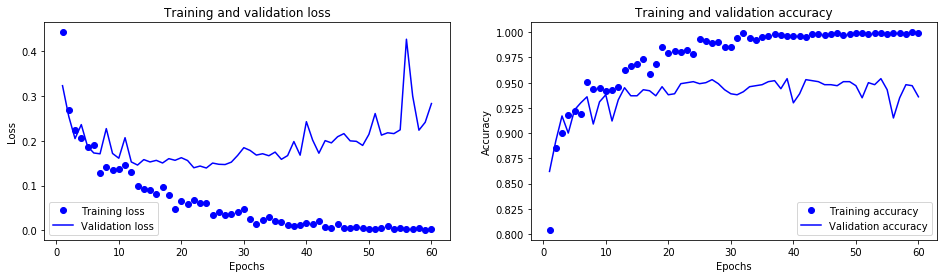

In [10]:
plot_history(history)

According to training and validation loss, model is overfitting after 12 epochs.

In [7]:
model.save('transfer-learning-fine-tune.h5')

In [12]:
convolutional_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))
convolutional_base.trainable = True

for layer in convolutional_base.layers:
    if 'block5' in layer.name or 'block4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

convolutional_base.summary()
        
model = models.Sequential()
model.add(convolutional_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [13]:
history_after_dropout = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/15
100/100 [==============================] - 37s 367ms/step - loss: 0.4115 - acc: 0.8010 - val_loss: 0.2565 - val_acc: 0.8930
Epoch 2/15
100/100 [==============================] - 36s 361ms/step - loss: 0.2327 - acc: 0.9015 - val_loss: 0.1900 - val_acc: 0.9210
Epoch 3/15
100/100 [==============================] - 36s 362ms/step - loss: 0.1957 - acc: 0.9085 - val_loss: 0.1641 - val_acc: 0.9330
Epoch 4/15
100/100 [==============================] - 37s 366ms/step - loss: 0.2194 - acc: 0.9095 - val_loss: 0.1456 - val_acc: 0.9370
Epoch 5/15
100/100 [==============================] - 36s 360ms/step - loss: 0.1383 - acc: 0.9430 - val_loss: 0.1312 - val_acc: 0.9480
Epoch 6/15
100/100 [==============================] - 36s 365ms/step - loss: 0.1547 - acc: 0.9355 - val_loss: 0.1306 - val_acc: 0.9480
Epoch 7/15
100/100 [==============================] - 37s 365ms/step - loss: 0.1008 - acc: 0.9610 - val_loss: 0.1239 - val_acc: 0.9520
Epoch 8/15
100/100 [==============================] - 3

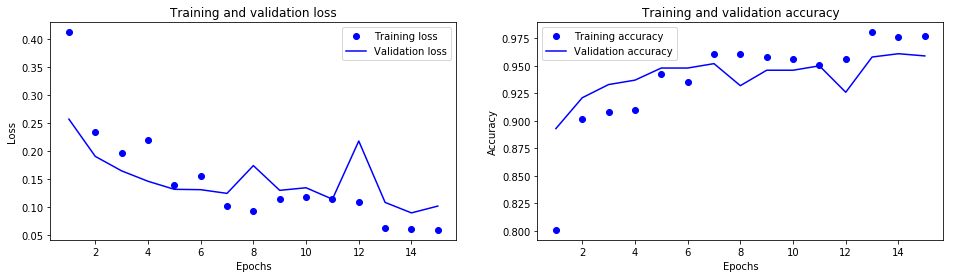

[0.14068273655453231, 0.95159999203681944]


In [14]:
plot_history(history_after_dropout)
print(model.evaluate_generator(test_generator))

model.save('transfer-learning-fine-tune-2.h5')

Dropout regularized model gives significant accuracy boost.

In [22]:
submission = model.predict_generator(submission_generator)

In [59]:
import pandas as pd 

df = pd.DataFrame({
    'id' : range(1, len(submission) + 1),
    'label': submission.reshape(12500)
})

df.to_csv('submission.csv', index = False)